<a href="https://colab.research.google.com/github/IgorJoaquimn/webp-compression/blob/main/TP_ICV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alunos:**
O objetivo deste trabalho é comprimir uma imagem passada como entrada. O método desenvolvido pode ser com ou sem perdas [reference](https://developers.google.com/speed/webp/docs/compression)

## Definição do Pipeline de Compressão
`[macroblocks -> preditive pixel -> residuals-> transform coding DCT -> quantization -> Arithmetic entropy encoding]`

O pipeline de compressão no formato WebP segue uma série de etapas projetadas para reduzir eficientemente o tamanho dos dados da imagem.
1. Primeiramente, a imagem é dividida em blocos menores chamados macroblocos, que são mais fáceis de processar individualmente.
2. Em seguida, a compressão preditiva é aplicada, onde os valores dos pixels são preditos com base nos valores dos pixels vizinhos, resultando em predições de pixels.
3. A diferença entre os valores reais dos pixels e os valores preditos é calculada, gerando os resíduos (residuals).
4. Esses resíduos são então submetidos à codificação por transformada (transform coding) utilizando a Transformada Cosseno Discreta (DCT), que converte os dados de espaço de imagem para espaço de frequência, concentrando a maior parte da informação útil em poucos coeficientes.
5. Posteriormente, esses coeficientes são quantizados, reduzindo a precisão de alguns deles para permitir uma compressão mais eficiente.
6. Finalmente, os coeficientes quantizados são codificados utilizando a codificação entrópica aritmética (Arithmetic entropy encoding), que reduz ainda mais o tamanho dos dados ao eliminar redundâncias estatísticas.

In [427]:
import cv2
import numpy as np
from scipy import fftpack
import struct
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

#### Funções Auxiliares


In [428]:
# funções auxiliares
def show_image(image, title=""):
    """Display the image."""
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    # plt.show()


def get_2D_dct(img):
    """ Obter a Transformada de Cosseno 2D da Imagem
    """
    # Aplica a Transformada Discreta de Cosseno (DCT) na imagem
    # Primeiro aplica a DCT ao longo das colunas (transposta),
    # depois aplica a DCT ao longo das linhas e retorna o resultado.
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Obter a Transformada Inversa de Cosseno 2D da Imagem
    """
    # Aplica a Transformada Discreta de Cosseno Inversa (IDCT) nos coeficientes
    # Primeiro aplica a IDCT ao longo das colunas (transposta),
    # depois aplica a IDCT ao longo das linhas e retorna o resultado.
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    img = Image.fromarray(img)
    return img

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)


def reconstruct_image(blocks, height, width, block_size):
  """Reconstruct the image based on the macroblocks."""
  macroblocks_coords = divide_into_macroblocks(height, width, block_size)
  reconstructed_image = np.zeros((height, width))

  for i,macroblock in enumerate(macroblocks_coords):
    y,x = macroblock
    reconstructed_image[y:y+block_size, x:x+block_size] = blocks[i]

  return reconstructed_image

quantization_matrix = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
                                 [12, 12, 14, 19, 26, 58, 60, 55],
                                 [14, 13, 16, 24, 40, 57, 69, 56],
                                 [14, 17, 22, 29, 51, 87, 80, 62],
                                 [18, 22, 37, 56, 68, 109, 103, 77],
                                 [24, 35, 55, 64, 81, 104, 113, 92],
                                 [49, 64, 78, 87, 103, 121, 120, 101],
                                 [72, 92, 95, 98, 112, 100, 103, 99]]).astype(float)
# data = [
#     [1, 1, 1, 2, 2, 4, 5, 6],
#     [1, 1, 1, 2, 3, 6, 6, 6],
#     [1, 1, 2, 2, 4, 6, 7, 6],
#     [1, 2, 2, 3, 5, 9, 8, 6],
#     [2, 2, 4, 6, 7, 11, 10, 8],
#     [2, 4, 6, 6, 8, 10, 11, 9],
#     [5, 6, 8, 9, 10, 12, 12, 10],
#     [7, 9, 10, 10, 11, 10, 10, 10]
# ]

# data = [
#     [1, 1, 1, 1, 1, 2, 2, 2],
#     [1, 1, 1, 1, 1, 2, 2, 2],
#     [1, 1, 1, 1, 2, 2, 3, 2],
#     [1, 1, 1, 1, 2, 3, 3, 2],
#     [1, 1, 1, 2, 3, 4, 4, 3],
#     [1, 1, 2, 3, 3, 4, 5, 4],
#     [2, 3, 3, 3, 4, 5, 5, 4],
#     [3, 4, 4, 4, 4, 4, 4, 4]
# ]

# data = [
#     [1, 1, 1, 2],
#     [1, 1, 1, 2],
#     [1, 1, 2, 2],
#     [2, 2, 2, 2]
# ]

quantization_matrix = np.array(quantization_matrix).astype(float)

# print(matrix)


* Algoritmo de predição retirado de
  *  C., Anil & da, Lavanya Vaishnavi. (2023). Intra Prediction Algorithm for Video Frames of H.264. 8. 11357-11367.

In [429]:
# Prediction Functions
def H_PRED(left_column, block_size):
    """Horizontal prediction mode."""
    return np.tile(left_column, (block_size, 1))

def V_PRED(above_row, block_size):
    """Vertical prediction mode."""
    return np.tile(above_row, (block_size, 1)).T

def DC_PRED(above_row, left_column, block_size):
    """DC prediction mode."""
    dc_value = int((np.sum(above_row) + np.sum(left_column)) / (2 * block_size))
    return np.full((block_size, block_size), dc_value)

def TM_PRED(above_row, left_column, above_left_pixel, block_size):
    """TrueMotion prediction mode."""
    pred_block = np.zeros((block_size, block_size))

    # Fill the first row using the above_row
    pred_block[0, :] = above_row[-block_size:]

    # Fill the first column using the left_column
    pred_block[:, 0] = left_column[-block_size:]

    # Fill the rest of the block using horizontal differences
    for i in range(1, block_size):
        for j in range(1, block_size):
            pred_block[i, j] = above_left_pixel + left_column[i] - above_row[j]

    return pred_block

def I_PRED(macroblock,block_size=8):
  return macroblock

def Z_PRED(macroblock,block_size=8):
  return np.zeros((block_size, block_size))

#### Definição do código do pipeline de compressão

In [430]:
def divide_into_macroblocks(height, width, block_size):
    """Divide the image into macroblocks of given size and return their coordinates."""
    macroblock_coords = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            macroblock_coords.append((y, x))
    return macroblock_coords

def predict_pixel(image, macroblock_coords, block_size=8):
    """Predict pixel values based on neighboring pixels and return the best prediction along with its encoded bytes."""
    # Extract coordinates
    y, x = macroblock_coords

    # Get neighboring pixels
    left_column = image[y:y+block_size, max(x-1, 0)]
    above_row = image[max(y-1, 0), x:x+block_size]
    above_left_pixel = image[max(y-1, 0), max(x-1, 0)]
    macroblock = image[y:y+block_size, x:x+block_size]

    # Define prediction functions with their respective parameters and struct format strings
    prediction_functions = [
        (H_PRED,  (left_column, block_size),                             f">B {block_size*32}s "),
        (V_PRED,  (above_row, block_size),                               f">B {block_size*32}s "),
        (DC_PRED, (above_row, left_column, block_size),                  f">B {block_size*32}s {block_size*32}s"),
        (TM_PRED, (above_row, left_column, above_left_pixel, block_size),f">B {block_size*32}s {block_size*32}s"),
        # (I_PRED,  (macroblock,block_size),f">B {block_size*32}s {block_size*32}s")
        (Z_PRED,  (macroblock,block_size),f">B {block_size*32}s {block_size*32}s")
    ]

    min_sad = float('inf')
    best_prediction = None
    best_prediction_function = None
    best_struct_format = None

    for i, (prediction_function, params, struct_format) in enumerate(prediction_functions):
        pred_block = prediction_function(*params)
        sad = np.sum(np.abs(image[y:y+block_size, x:x+block_size] - pred_block))
        if sad < min_sad:
            min_sad = sad
            best_prediction = pred_block
            best_prediction_function = prediction_functions[i]

    return best_prediction, best_prediction_function

def compute_residuals(original_macroblock, predicted_macroblock):
    """Compute the residuals (differences between original and predicted macroblocks)."""
    return predicted_macroblock - original_macroblock

def transform_coding_dct(residual_macroblock):
    """Apply Discrete Cosine Transform (DCT) to the residual macroblock."""
    return fftpack.dct(fftpack.dct(residual_macroblock.T, norm='ortho').T, norm='ortho')

def quantization(transformed_macroblock, quantization_matrix, block_size=8,baseline = 3.5, variance_factor=-0.25):
    """Quantize the transformed macroblock with adaptive quantization."""
    height, width = transformed_macroblock.shape

    # Calculate the variance of the block
    variance = np.var(transformed_macroblock)
    quantization_step = np.log(variance) * variance_factor + baseline
    # Apply quantization matrix and adaptive quantization
    quantized_block = np.round(transformed_macroblock / (quantization_matrix * quantization_step))

    return quantized_block,quantization_step

def arithmetic_entropy_encoding(quantized_macroblock):
    """Encode the quantized macroblock using arithmetic entropy encoding."""
    # Flatten the quantized macroblock to a 1D array
    pass

# huffman
from heapq import heappush, heappop, heapify
from collections import defaultdict

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    # return encoded_data

### Uso

In [431]:
import requests

url = "https://thispersondoesnotexist.com/"
# url = "http://andrewd.ces.clemson.edu/images/pgm/lena512.pgm"
response = requests.get(url)
with open("lena512.pgm", 'wb') as f:
    f.write(response.content)

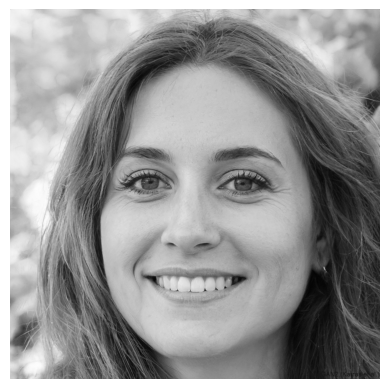

In [432]:
image = cv2.imread('lena512.pgm',0)  # Example random image
image = image.astype(np.float32)
show_image(image)

In [433]:
image = image.astype(np.float32) - 128

In [434]:
height, width = image.shape
block_size = 8
macroblocks = divide_into_macroblocks(height, width, block_size)

### Preditive Coding

No contexto do encoding preditivo, as imagens preditas são geradas usando algoritmos que tentam prever um bloco de pixels com base em pixels vizinhos. As predições podem ser feitas de várias maneiras, como predição horizontal (H_PRED), predição vertical (V_PRED), predição de média (DC_PRED), predição de média temporal (TM_PRED), entre outras. Cada uma dessas técnicas de predição tenta estimar os valores dos pixels com base em padrões específicos na imagem.

Nesse algoritmo, para cada macrobloco, é escolhido o padrão de predição que apresenta menor erro.

In [435]:
predicted_images = { "H_PRED": np.zeros_like(image),
                     "V_PRED": np.zeros_like(image),
                     "DC_PRED": np.zeros_like(image),
                     "TM_PRED": np.zeros_like(image)
                     }

for macroblock_coords in macroblocks:
  y, x = macroblock_coords
  left_column = image[y:y+block_size, max(x-1, 0)]
  above_row = image[max(y-1, 0), x:x+block_size]
  above_left_pixel = image[max(y-1, 0), max(x-1, 0)]
  macroblock = image[y:y+block_size, x:x+block_size]

  prediction_functions = [
      (H_PRED,  (left_column, block_size),                             "H_PRED"),
      (V_PRED,  (above_row, block_size),                               "V_PRED"),
      (DC_PRED, (above_row, left_column, block_size),                  "DC_PRED"),
      (TM_PRED, (above_row, left_column, above_left_pixel, block_size),"TM_PRED"),
  ]

  for prediction_function, params, title in prediction_functions:
      pred_block = prediction_function(*params)
      predicted_images[title][y:y+block_size, x:x+block_size] = pred_block

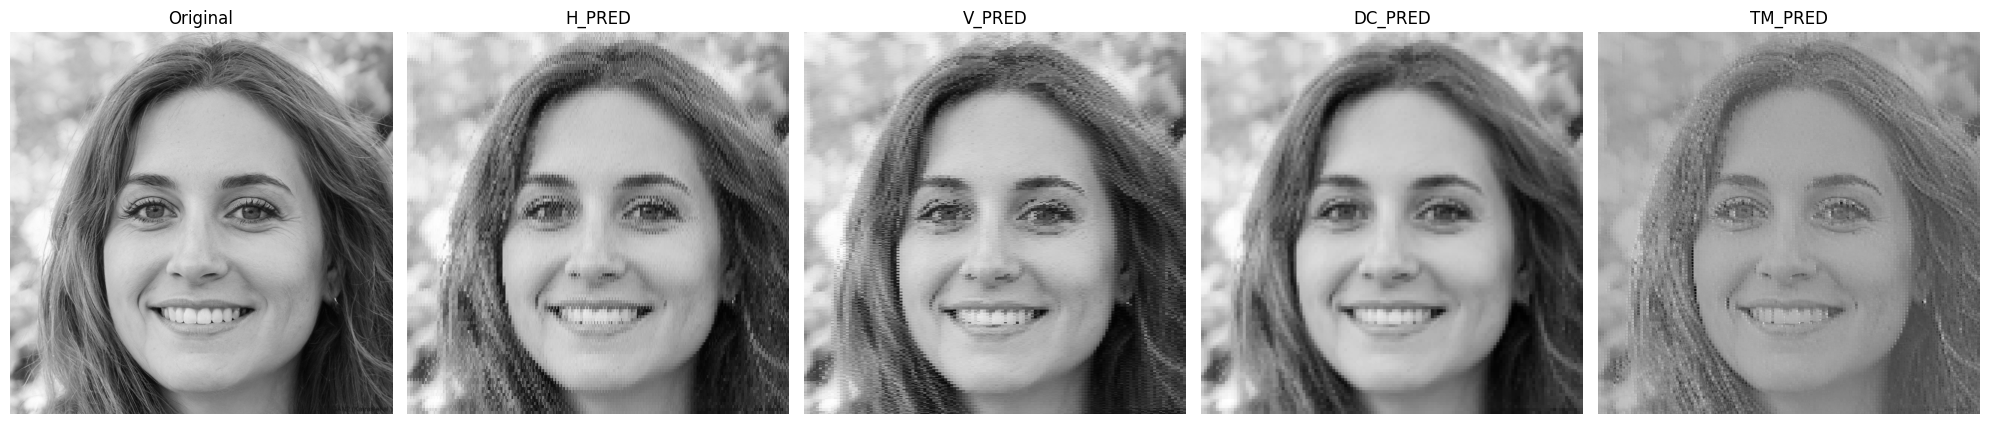

In [436]:
predicted_images_list = [(title, img) for title, img in predicted_images.items()]

num_predictions = len(predicted_images_list)
plt.figure(figsize=(20, 10))
plt.subplot(1, num_predictions + 1, 1)
show_image(image, 'Original')

# Exibir todas as imagens preditivas
for i, (title, pred_image) in enumerate(predicted_images_list):
    plt.subplot(1, num_predictions + 1, i + 2)
    show_image(pred_image, title)

plt.tight_layout()
plt.show()

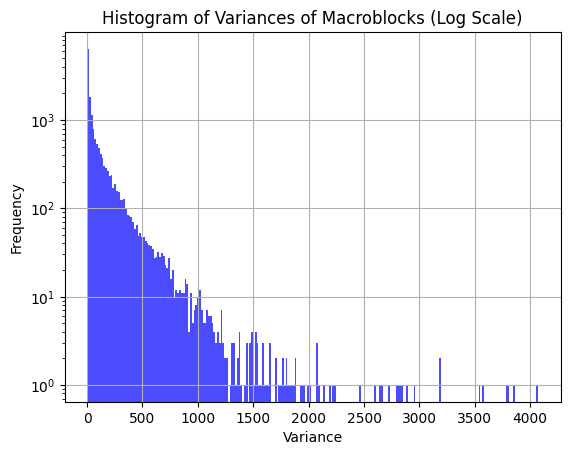

In [437]:
def calculate_macroblock_variances(image, block_size):
    """Calculate variances of macroblocks."""
    height, width = image.shape[:2]
    macroblock_variances = []

    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            macroblock = image[y:y+block_size, x:x+block_size]
            variance = np.var(macroblock)
            macroblock_variances.append(variance)

    return np.array(macroblock_variances)

# Calculate variances of macroblocks
macroblock_variances = calculate_macroblock_variances(image, block_size)

# Plot histogram of variances in log-log scale
plt.hist(macroblock_variances, bins=250, color='blue', alpha=0.7, log=True)
plt.title('Histogram of Variances of Macroblocks (Log Scale)')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

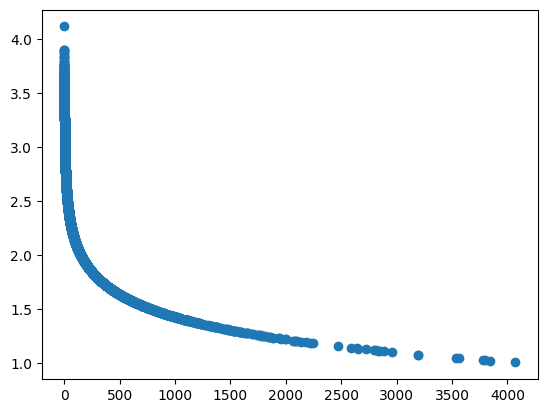

In [438]:
f = lambda x: np.log(x)*-0.3 + 3.5
plt.scatter(macroblock_variances,f(macroblock_variances))

O histograma das variações dos macroblocos nos fornece informações sobre a distribuição dos detalhes na imagem. Com base nessa distribuição, podemos selecionar thresholds apropriados para a quantização. Esses thresholds determinam a quantidade de detalhes que serão preservados ou descartados durante a compressão da imagem

#### Compressão

In [439]:
transformed_residuals_macroblocks = []
residualss = []
predictions = []
header = []

for macroblock_coords in macroblocks:
  y, x = macroblock_coords
  macroblock = image[y:y+block_size, x:x+block_size]
  # Predict
  predicted_macroblock,best_prediction_function  = predict_pixel(image,macroblock_coords,block_size=block_size)
  predictions.append(predicted_macroblock)

  # Calculate the residuals
  residuals = compute_residuals(macroblock, predicted_macroblock)
  residualss.append(residuals)

  # Transformation and Quantization
  transformed_residuals = transform_coding_dct(residuals)
  quantized_transformed_residuals, quantization_step = quantization(transformed_residuals, quantization_matrix)

  # Save in the matrix
  transformed_residuals_macroblocks.append(quantized_transformed_residuals)

  header.append(best_prediction_function + tuple([quantization_step]))

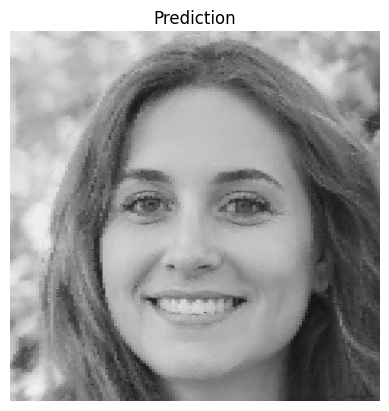

In [440]:
reconstructed_image = reconstruct_image(predictions, height, width, block_size)
show_image(reconstructed_image, 'Prediction')

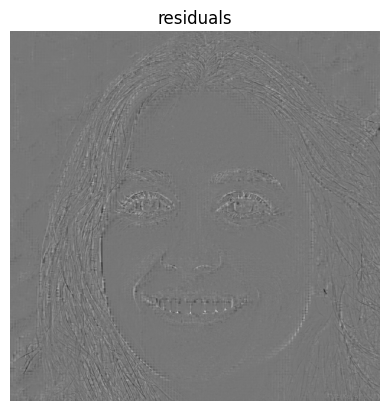

In [441]:
reconstructed_image = reconstruct_image(residualss, height, width, block_size)
show_image(reconstructed_image, 'residuals')

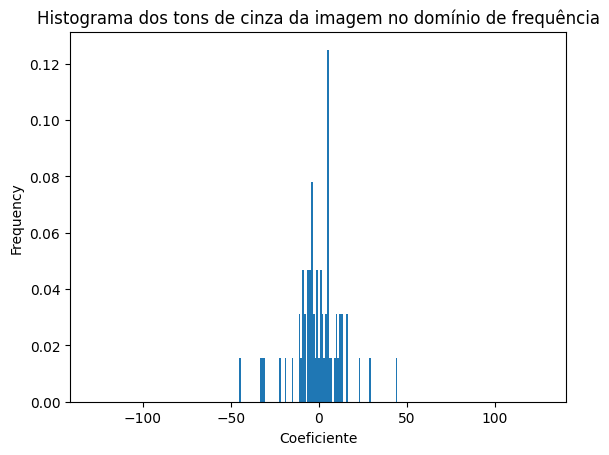

In [442]:
# Compute histogram of transformed residuals
hist, bins = np.histogram(transformed_residuals, bins=256, range=(-128, 128))

# Normalize histogram to obtain frequencies
hist = hist / np.sum(hist)

# Plot histogram
plt.bar(bins[:-1], hist, width=1)
plt.title("Histograma dos tons de cinza da imagem no domínio de frequência")
plt.xlabel("Coeficiente")
plt.ylabel("Frequency")
plt.show()

In [443]:
# Create dictionary mapping pixel intensity values to their frequencies
symb2freq = defaultdict(float)
for intensity, freq in enumerate(hist):
    symb2freq[intensity] = freq

huff = encode(symb2freq)

In [444]:
nbits = 0
for i in range(0,256):
    nbits += len(huff[i][1]) * hist[huff[i][0]] * height * width

# bits per pixel
bpp = nbits / (height * width)

print ("\n",13*"-","Summary",13*"-")
print ("Original Size: %d bytes" % ((height * width) * 32))
print ("Residual size: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel" % bpp)
print ("Compression ratio (without header): %5.3f" % (8/bpp))


 ------------- Summary -------------
Original Size: 33554432 bytes
Residual size: 632832 bytes
4.828 bits/pixel
Compression ratio (without header): 1.657


## Decompressao


In [445]:
def dequantization(residual_macroblock, quantization_matrix, step = 5):
    """Quantize the residual macroblock with adaptive quantization."""
    # Apply quantization matrix and adaptive quantization
    quantized_block = (quantization_matrix * step) * residual_macroblock
    # quantized_block = residual_macroblock

    return quantized_block

def transform_coding_idct(coefficients):
    """Apply Discrete Cosine Transform (DCT) to the residual macroblock."""

    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


In [446]:
macroblocks_coords = divide_into_macroblocks(height, width, block_size)

In [447]:
decompress = []

for i,macroblock in enumerate(transformed_residuals_macroblocks):
  macroblock = transformed_residuals_macroblocks[i]
  preditive_f,params,_,step = header[i]

  # quantization
  dequantized_block = dequantization(macroblock,quantization_matrix,step)
  # inverse dct
  residual  = transform_coding_idct(dequantized_block)
  # preditive decoding
  predicted_block = preditive_f(*params)
  original = predicted_block - residual
  decompress.append(original.round().astype(float))

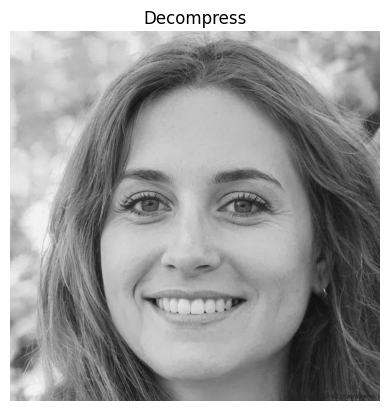

In [448]:
reconstructed_image = reconstruct_image(decompress, height, width, block_size) + 128
show_image(reconstructed_image, 'Decompress')

In [449]:
print ("RMSE: %5.3f" % rmse(image + 128, reconstructed_image))
print ("PSNR: %5.3f" % psnr(image + 128, reconstructed_image))

RMSE: 4.965
PSNR: 34.212


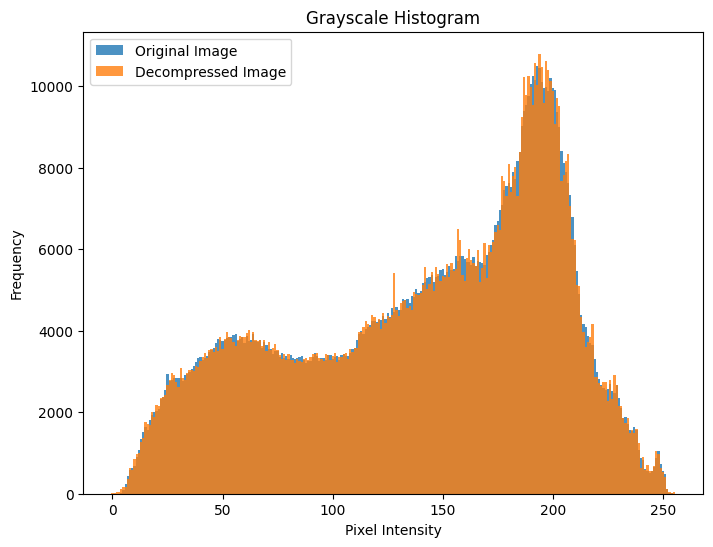

In [450]:
plt.figure(figsize=(8, 6))

hist, bins = np.histogram(image.flatten() + 128, bins=256, range=(0, 256))
plt.bar(bins[:-1], hist, width=1, alpha=0.8,label="Original Image")

hist, bins = np.histogram(reconstructed_image.flatten(), bins=256, range=(0, 256))
plt.bar(bins[:-1], hist, width=1, alpha=0.8,label="Decompressed Image")


plt.title('Grayscale Histogram')
plt.xlabel('Pixel Intensity')

plt.ylabel('Frequency')
plt.legend()
plt.show()

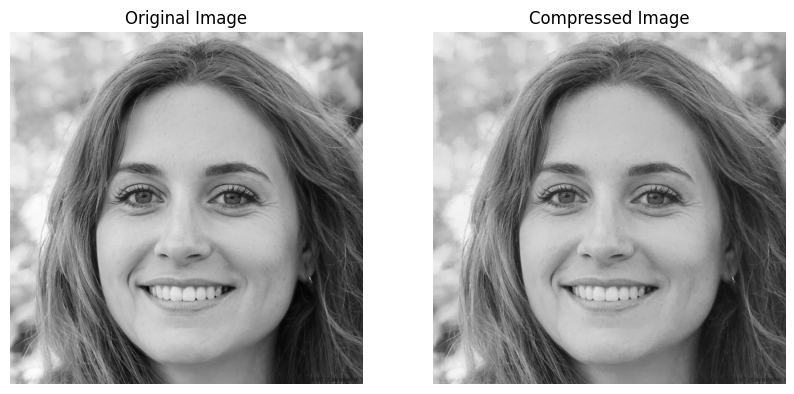

In [451]:
plt.figure(figsize=(10, 5))  # Create a figure with a specific size

# Display the original image
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')  # Turn off axis

# Display the reconstructed (compressed) image
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')  # Turn off axis

# Show the plot
plt.show()
